In [1]:
!pip install -qq llama-index llama-index-callbacks-arize-phoenix "openai>=1"  openai pyvis datasets pycm

In [2]:
#!pip install "llama_index==0.9.40"

In [6]:
# Standard library imports
import json
import os
import re

# Third-party library imports
from getpass import getpass
from pyvis.network import Network
import pandas as pd
from sqlalchemy import (Column, Integer, MetaData, String, Table, create_engine, select, column)
from tqdm import tqdm
import nest_asyncio
from typing import Any, Dict, List, Optional, Sequence, Set, Tuple, cast

# Local module imports
from llama_index.core import SQLDatabase, SimpleDirectoryReader, Document, set_global_handler
from llama_index.core.agent import (AgentChatResponse, AgentRunner, QueryPipelineAgentWorker, Task)
from llama_index.core.agent.react.types import (ActionReasoningStep, ObservationReasoningStep, ResponseReasoningStep)
from llama_index.core.callbacks import CallbackManager
from llama_index.core.query_pipeline import (AgentFnComponent, AgentInputComponent, CustomAgentComponent, QueryComponent, ToolRunnerComponent, InputComponent, Link, QueryPipeline)
from llama_index.core.tools import BaseTool, QueryEngineTool, FunctionTool
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.llms.openai import OpenAI
from llama_index.core.query_engine import NLSQLTableQueryEngine
from llama_index.core.response import Response
from llama_index.core.agent.react.output_parser import ReActOutputParser
from llama_index.core.agent import ReActChatFormatter

import phoenix as px
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations

# Apply settings and initializations
pd.set_option("display.max_colwidth", 1000)
nest_asyncio.apply()


/Users/jasonlopatecki/vs_projects/haystack-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import pandas as pd
import openai
import ast
import os
import numpy as np
import matplotlib.pyplot as plt
from phoenix.experimental.evals import (
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
import phoenix.experimental.evals.templates.default_templates as templates
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report


In [41]:
from phoenix.experimental.evals.templates.default_templates import (SQL_GEN_EVAL_PROMPT_TEMPLATE, SQL_GEN_EVAL_PROMPT_RAILS_MAP)

In [8]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

In [10]:
!curl "https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip" -O ./chinook.zip
!unzip ./chinook.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  298k  100  298k    0     0  1478k      0 --:--:-- --:--:-- --:--:-- 1484k
curl: (6) Could not resolve host: .
Archive:  ./chinook.zip
  inflating: chinook.db              


In [11]:
engine = create_engine("sqlite:///chinook.db")
sql_database = SQLDatabase(engine)

In [12]:
session = px.launch_app()
set_global_handler("arize_phoenix")

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [13]:
sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["albums", "tracks", "artists"],
    verbose=True,
)
sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql_tool",
    description=(
        "Useful for translating a natural language query into a SQL query"
    ),
)

In [15]:
questions = [
    "What is the name of the artist with ID 5?",
    "List all tracks in the album with ID 3.",
    "How many tracks does the artist named 'Aerosmith' have?",
    "Find the oldest song in the database.",
    "What is the duration of the track with ID 10?",
    "List the names of all albums released in 2020.",
    "How many artists are in the database?",
    "Which artist has the most tracks in the database?",
    "List all tracks in the 'Pop' genre.",
    "What is the average length of tracks in the database?",
    "Find the most recent track.",
    "List the top 5 longest tracks in the database.",
    "Which album has the highest number of tracks?",
    "List all artists who have released more than 3 albums.",
    "What is the shortest track in the database?",
    "Find all albums released by 'The Beatles'.",
    "How many tracks are in the 'Rock' genre?",
    "List the names of all tracks released before 2000.",
    "What is the total duration of the album with ID 7?",
    "Find the artist who released the album 'Thriller'.",
    "List the names of all albums by 'Pink Floyd'.",
    "How many albums have been released between 1990 and 2000?",
    "What genres are covered by the artist 'David Bowie'?",
    "List the top 10 most played tracks.",
    "Which artist has the longest total track duration in the database?",
    "Find all tracks with a duration longer than 5 minutes.",
    "How many tracks does each album contain on average?",
    "List all albums sorted by release date.",
    "Which artist's albums have the highest average ratings?",
    "Find the total duration of all tracks by 'Michael Jackson'.",
    "How many tracks in the database are instrumental?",
    "List the names of all tracks by artists with the name starting with 'J'.",
    "What is the most common genre in the database?",
    "Find the average album length in minutes.",
    "How many artists have only one album in the database?",
    "List all tracks from the album with the most number of tracks.",
    "Which artist has released the most albums?",
    "Find the total number of tracks produced by 'Eminem'.",
    "How many albums in the database have no tracks?",
    "List the name and duration of the longest track in each album.",
    "What is the average number of tracks per album?",
    "Find all albums that have more than 10 tracks.",
    "How many tracks in the database are longer than the average track length?",
    "List the albums released by the artist with the most albums.",
    "Which year has the highest number of album releases?",
    "Find the total playtime of all tracks in the 'Jazz' genre.",
    "How many artists have names longer than 10 characters?",
    "List all song genres found in the database.",
    "What is the average track length of the tracks?",
    "How many albums were released on average by each artist?"
]

print(questions)


['What is the name of the artist with ID 5?', 'List all tracks in the album with ID 3.', "How many tracks does the artist named 'Aerosmith' have?", 'Find the oldest song in the database.', 'What is the duration of the track with ID 10?', 'List the names of all albums released in 2020.', 'How many artists are in the database?', 'Which artist has the most tracks in the database?', "List all tracks in the 'Pop' genre.", 'What is the average length of tracks in the database?', 'Find the most recent track.', 'List the top 5 longest tracks in the database.', 'Which album has the highest number of tracks?', 'List all artists who have released more than 3 albums.', 'What is the shortest track in the database?', "Find all albums released by 'The Beatles'.", "How many tracks are in the 'Rock' genre?", 'List the names of all tracks released before 2000.', 'What is the total duration of the album with ID 7?', "Find the artist who released the album 'Thriller'.", "List the names of all albums by 'P

In [16]:

## Agent Input Component
## This is the component that produces agent inputs to the rest of the components
## Can also put initialization logic here.
def agent_input_fn(task: Task, state: Dict[str, Any]) -> Dict[str, Any]:
    """Agent input function.

    Returns:
        A Dictionary of output keys and values. If you are specifying
        src_key when defining links between this component and other
        components, make sure the src_key matches the specified output_key.

    """
    # initialize current_reasoning
    if "current_reasoning" not in state:
        state["current_reasoning"] = []
    reasoning_step = ObservationReasoningStep(observation=task.input)
    state["current_reasoning"].append(reasoning_step)
    return {"input": task.input}


agent_input_component = AgentInputComponent(fn=agent_input_fn)

In [17]:
## define prompt function
def react_prompt_fn(
    task: Task, state: Dict[str, Any], input: str, tools: List[BaseTool]
) -> List[ChatMessage]:
    # Add input to reasoning
    chat_formatter = ReActChatFormatter()
    return chat_formatter.format(
        tools,
        chat_history=task.memory.get() + state["memory"].get_all(),
        current_reasoning=state["current_reasoning"],
    )


react_prompt_component = AgentFnComponent(
    fn=react_prompt_fn, partial_dict={"tools": [sql_tool]}
)

In [18]:
## Agent Output Component
## Process reasoning step/tool outputs, and return agent response
def finalize_fn(
    task: Task,
    state: Dict[str, Any],
    reasoning_step: Any,
    is_done: bool = False,
    tool_output: Optional[Any] = None,
) -> Tuple[AgentChatResponse, bool]:
    """Finalize function.

    Here we take the latest reasoning step, and a tool output (if provided),
    and return the agent output (and decide if agent is done).

    This function returns an `AgentChatResponse` and `is_done` tuple. and
    is the last component of the query pipeline. This is the expected
    return type for any query pipeline passed to `QueryPipelineAgentWorker`.

    """
    current_reasoning = state["current_reasoning"]
    current_reasoning.append(reasoning_step)
    # if tool_output is not None, add to current reasoning
    if tool_output is not None:
        observation_step = ObservationReasoningStep(
            observation=str(tool_output)
        )
        current_reasoning.append(observation_step)
    if isinstance(current_reasoning[-1], ResponseReasoningStep):
        response_step = cast(ResponseReasoningStep, current_reasoning[-1])
        response_str = response_step.response
    else:
        response_str = current_reasoning[-1].get_content()

    # if is_done, add to memory
    # NOTE: memory is a reserved keyword in `state`, but you can add your own too
    if is_done:
        state["memory"].put(
            ChatMessage(content=task.input, role=MessageRole.USER)
        )
        state["memory"].put(
            ChatMessage(content=response_str, role=MessageRole.ASSISTANT)
        )

    return AgentChatResponse(response=response_str), is_done


class OutputAgentComponent(CustomAgentComponent):
    """Output agent component."""

    tool_runner_component: ToolRunnerComponent
    output_parser: ReActOutputParser

    def __init__(self, tools, **kwargs):
        tool_runner_component = ToolRunnerComponent(tools)
        super().__init__(
            tool_runner_component=tool_runner_component,
            output_parser=ReActOutputParser(),
            **kwargs
        )

    def _run_component(self, **kwargs: Any) -> Any:
        """Run component."""
        chat_response = kwargs["chat_response"]
        task = kwargs["task"]
        state = kwargs["state"]
        reasoning_step = self.output_parser.parse(
            chat_response.message.content
        )
        if reasoning_step.is_done:
            return {
                "output": finalize_fn(
                    task, state, reasoning_step, is_done=True
                )
            }
        else:
            tool_output = self.tool_runner_component.run_component(
                tool_name=reasoning_step.action,
                tool_input=reasoning_step.action_input,
            )
            return {
                "output": finalize_fn(
                    task,
                    state,
                    reasoning_step,
                    is_done=False,
                    tool_output=tool_output,
                )
            }

    @property
    def _input_keys(self) -> Set[str]:
        return {"chat_response"}

    @property
    def _optional_input_keys(self) -> Set[str]:
        return {"is_done", "tool_output"}

    @property
    def _output_keys(self) -> Set[str]:
        return {"output"}

    @property
    def sub_query_components(self) -> List[QueryComponent]:
        return [self.tool_runner_component]


react_output_component = OutputAgentComponent([sql_tool])

In [19]:
qp = QueryPipeline(
    modules={
        "agent_input": agent_input_component,
        "react_prompt": react_prompt_component,
        "llm": OpenAI(model="gpt-4-1106-preview"),
        "react_output": react_output_component,
    },
    verbose=True,
)
qp.add_chain(["agent_input", "react_prompt", "llm", "react_output"])

In [24]:
agent_worker = QueryPipelineAgentWorker(qp)
agent = AgentRunner(agent_worker, callback_manager=CallbackManager([]))
response = agent.chat(
    "Is Aerosmith in this database?"
)
print(str(response))

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='42a135b4-26e3-419b-8982-e17d7e7a0bcc' input='Is Aerosmith in this database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encodin...

> Running module react_prompt with input: 
input: Is Aerosmith in this database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The user is asking if Aerosmith is in a database, but I don't have direct access to a database to check this information. Howev

In [52]:
all_sql_queries = []
all_ans = []
for question in tqdm(questions):
  agent_worker = QueryPipelineAgentWorker(qp)
  agent = AgentRunner(agent_worker, callback_manager=CallbackManager([]))
  task = agent.create_task(question)
  # Need to manually run the task as to recover the convo_history
  step_output = agent.run_step(task.task_id)
  ans = str(step_output)
  sql_query_match = re.search(r"\'sql_query\': \'([^\']+)\'", ans)

  if not sql_query_match:
    print(ans)
  # Extract the sql_query if the pattern is found
  sql_query = sql_query_match.group(1) if sql_query_match else None

  # Regular expression to extract the response
  response_match = re.search(r"response=\'([^\']+)\'", ans)

  # Extract the response if the pattern is found
  response = response_match.group(1) if response_match else None

  print("SQL Query:", sql_query)
  print("Response:", response)
  all_ans.append(response)
  all_sql_queries.append(sql_query)


  0%|          | 0/50 [00:00<?, ?it/s]

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='9de3a197-35f0-4538-ac6a-ad1d0eb56802' input='What is the name of the artist with ID 5?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode ...

> Running module react_prompt with input: 
input: What is the name of the artist with ID 5?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. I need to use a tool to help me answer the question.
Action: sql_tool
A

  2%|▏         | 1/50 [00:04<03:40,  4.51s/it]

SQL Query: SELECT Name\nFROM artists\nWHERE ArtistId = 5;
Response: The artist with ID 5 is Alice In Chains.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='e6fbed9a-2f06-48ae-b400-84e255b2340d' input='List all tracks in the album with ID 3.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of...

> Running module react_prompt with input: 
input: List all tracks in the album with ID 3.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The curre

  4%|▍         | 2/50 [00:12<05:10,  6.47s/it]

SQL Query: SELECT Name, Composer \nFROM tracks \nWHERE AlbumId = 3\nORDER BY Name;
Response: The tracks in the album with ID 3 are "Fast As a Shark" composed by F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman, "Princess of the Dawn" composed by Deaffy & R.A. Smith-Diesel, and "Restless and Wild" composed by F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='47de1d4b-c11f-4fbb-a704-5026aacbbf9e' input="How many tracks does the artist named 'Aerosmith' have?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method En...

> Running module react_prompt with input: 
input: How many tracks does the artist named 'Aerosmith' have?

> Running module llm with input: 
messages: 

  6%|▌         | 3/50 [00:17<04:38,  5.92s/it]

Observation: {'output': ToolOutput(content="The artist named 'Aerosmith' has a total of 15 tracks.", tool_name='sql_tool', raw_input={'input': "How many tracks does the artist named 'Aerosmith' have?"}, raw_output=Response(response="The artist named 'Aerosmith' has a total of 15 tracks.", source_nodes=[NodeWithScore(node=TextNode(id_='91302661-ee9a-4f5a-a71a-06618cf38e14', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(15,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'91302661-ee9a-4f5a-a71a-06618cf38e14': {}, 'sql_query': "SELECT COUNT(tracks.TrackId) AS NumTracks\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Aerosmith'", 'result': [(15,)], 'col_keys': ['NumTracks']}))}
SQL Query: None
Response: No

  8%|▊         | 4/50 [00:23<04:26,  5.79s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds ASC\nLIMIT 1;
Response: The oldest song in the database is "É Uma Partida De Futebol" with a duration of 1071 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='7937c61c-57fa-449e-ba21-6819cd2f7428' input='What is the duration of the track with ID 10?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.enc...

> Running module react_prompt with input: 
input: What is the duration of the track with ID 10?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n

 10%|█         | 5/50 [00:30<04:37,  6.16s/it]

SQL Query: SELECT Milliseconds\nFROM tracks\nWHERE TrackId = 10;
Response: The duration of the track with ID 10 is 263497 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='ea7dd398-ceac-48dd-b02d-c4734f7bafad' input='List the names of all albums released in 2020.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.en...

> Running module react_prompt with input: 
input: List the names of all albums released in 2020.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_respo

 12%|█▏        | 6/50 [00:36<04:30,  6.15s/it]

Observation: {'output': ToolOutput(content='There are no albums released in 2020 in the database.', tool_name='sql_tool', raw_input={'input': 'List the names of all albums released in 2020.'}, raw_output=Response(response='There are no albums released in 2020 in the database.', source_nodes=[NodeWithScore(node=TextNode(id_='c29a3154-f3aa-42c0-b0a0-6ac5ddd711f5', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'c29a3154-f3aa-42c0-b0a0-6ac5ddd711f5': {}, 'sql_query': "SELECT Title\nFROM albums\nWHERE AlbumId IN (SELECT AlbumId FROM tracks WHERE strftime('%Y', tracks.Name) = '2020')", 'result': [], 'col_keys': ['Title']}))}
SQL Query: None
Response: There are no albums released in 2020 in the database.
> Running module agent_input with input: 
stat

 14%|█▍        | 7/50 [00:42<04:23,  6.13s/it]

SQL Query: SELECT COUNT(ArtistId) AS TotalArtists FROM artists
Response: There are a total of 275 artists in the database.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='68ae845a-dec7-4617-8727-406a24b10eda' input='Which artist has the most tracks in the database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding...

> Running module react_prompt with input: 
input: Which artist has the most tracks in the database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assis

 16%|█▌        | 8/50 [00:49<04:32,  6.48s/it]

SQL Query: SELECT artists.Name, COUNT(tracks.TrackId) AS TrackCount\nFROM artists\nJOIN albums ON artists.ArtistId = albums.ArtistId\nJOIN tracks ON albums.AlbumId = tracks.AlbumId\nGROUP BY artists.ArtistId\nORDER BY TrackCount DESC\nLIMIT 1;
Response: The artist with the most tracks in the database is Iron Maiden, with a total of 213 tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='b129b9c4-8766-421b-9cbb-f2127f141eb1' input="List all tracks in the 'Pop' genre." memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <En...

> Running module react_prompt with input: 
input: List all tracks in the 'Pop' genre.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='

 18%|█▊        | 9/50 [01:06<06:39,  9.75s/it]

Observation: {'output': ToolOutput(content="Here is a list of tracks in the 'Pop' genre: \n1. #9 Dream\n2. (There Is) No Greater Love (Teo Licks)\n3. Amy Amy Amy (Outro)\n4. Bate Lata\n5. Beautiful Boy\n6. Cold Turkey\n7. Daniela\n8. Dig-Dig, Lambe-Lambe (Ao Vivo)\n9. F**k Me Pumps\n10. Garotas do Brasil\n11. Gimme Some Truth\n12. Give Peace a Chance\n13. God\n14. Grow Old With Me\n15. Help Yourself\n16. I Heard Love Is Blind\n17. I'm Losing You\n18. Imagine\n19. In My Bed\n20. Instant Karma\n21. Intro / Stronger Than Me\n22. Isolation\n23. Jealous Guy\n24. Latinha de Cerveja\n25. Lavadeira\n26. Levada do Amor (Ailoviu)\n27. Mother\n28. My Love\n29. Nobody Told Me\n30. October Song\n31. Oh, My Love\n32. Pererê\n33. Power to the People\n34. Real Love\n35. Reboladeira\n36. Reggae Tchan\n37. Take the Box\n38. Tapa Aqui, Descobre Ali\n39. TriboTchan\n40. Watching the Wheels\n41. What Is It About Men\n42. Whatever Gets You Thru the Night\n43. Working Class Hero\n44. You Sent Me Flying / Che

 20%|██        | 10/50 [01:10<05:25,  8.14s/it]

SQL Query: SELECT AVG(Milliseconds) AS AverageLength\nFROM tracks
Response: The average length of tracks in the database is approximately 393,599 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='50b6e477-6850-40a7-afc2-4e71b21cedb5' input='Find the most recent track.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding '...

> Running module react_prompt with input: 
input: Find the most recent track.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...



 22%|██▏       | 11/50 [01:15<04:39,  7.16s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The user wants to find the most recent track, but I don't have enough context to answer directly. I need more information about where to find this track. It could be in a database,...

Could you please provide more details on where you would like to find the most recent track? Are you referring to a specific music platform or database?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='926efd45-ecfb-4b61-9456-71f04f9e60c8' input='List the top 5 longest tracks in the database.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.en...

> Running module react_prompt with input: 
input: List the top 5 longest tracks in the da

 24%|██▍       | 12/50 [01:23<04:36,  7.28s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds DESC\nLIMIT 5;
Response: The top 5 longest tracks in the database are "Occupation / Precipice" with a length of 5286953 milliseconds, "Through a Looking Glass" with a length of 5088838 milliseconds, "Greetings from Earth, Pt. 1" with a length of 2960293 milliseconds, "The Man With Nine Lives" with a length of 2956998 milliseconds, and "Battlestar Galactica, Pt. 2" with a length of 2956081 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='4893d82a-be07-4040-a085-509d02f94881' input='Which album has the highest number of tracks?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.enc...

> Running module react_prompt with input: 
input: Which a

 26%|██▌       | 13/50 [01:27<03:57,  6.42s/it]

SQL Query: SELECT Title AS album_name \nFROM albums \nORDER BY (SELECT COUNT(*) FROM tracks WHERE tracks.AlbumId = albums.AlbumId) DESC \nLIMIT 1
Response: The album with the most tracks is "Greatest Hits".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='dd758aac-d755-4e2d-9cb2-22a76d813b9a' input='List all artists who have released more than 3 albums.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Enc...

> Running module react_prompt with input: 
input: List all artists who have released more than 3 albums.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of anal

 28%|██▊       | 14/50 [01:34<03:52,  6.47s/it]

SQL Query: SELECT artists.Name, COUNT(albums.AlbumId) AS AlbumCount\nFROM artists\nJOIN albums ON artists.ArtistId = albums.ArtistId\nGROUP BY artists.ArtistId\nHAVING COUNT(albums.AlbumId) > 3\nORDER BY AlbumCount DESC;
Response: Some of the artists who have released more than 3 albums include Iron Maiden with 21 albums, Led Zeppelin with 14 albums, Deep Purple with 11 albums, Metallica and U2 with 10 albums each, Ozzy Osbourne with 6 albums, and Pearl Jam with 5 albums. Other artists with more than 3 albums include Various Artists, Faith No More, Foo Fighters, Lost, and Van Halen.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='1296373f-a6cc-460d-bc32-2dc218b10dd3' input='What is the shortest track in the database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_

 30%|███       | 15/50 [01:40<03:38,  6.25s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds\nLIMIT 1;
Response: The shortest track in the database is "É Uma Partida De Futebol" with a duration of 1071 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='ee8d0cb3-0f9e-417b-9633-e4d2d7b82a65' input="Find all albums released by 'The Beatles'." memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode...

> Running module react_prompt with input: 
input: Find all albums released by 'The Beatles'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n..

 32%|███▏      | 16/50 [01:46<03:36,  6.36s/it]

Observation: {'output': ToolOutput(content="There are no albums in the database released by 'The Beatles'.", tool_name='sql_tool', raw_input={'input': "Find all albums released by 'The Beatles'."}, raw_output=Response(response="There are no albums in the database released by 'The Beatles'.", source_nodes=[NodeWithScore(node=TextNode(id_='e291a8ba-186a-4e7f-b9e1-65d14833a4e1', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'e291a8ba-186a-4e7f-b9e1-65d14833a4e1': {}, 'sql_query': "SELECT AlbumId, Title\nFROM albums\nWHERE ArtistId = (SELECT ArtistId FROM artists WHERE Name = 'The Beatles');", 'result': [], 'col_keys': ['AlbumId', 'Title']}))}
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory':

 34%|███▍      | 17/50 [01:54<03:43,  6.76s/it]

Observation: {'output': ToolOutput(content="There are 1297 tracks in the 'Rock' genre.", tool_name='sql_tool', raw_input={'input': "How many tracks are in the 'Rock' genre?"}, raw_output=Response(response="There are 1297 tracks in the 'Rock' genre.", source_nodes=[NodeWithScore(node=TextNode(id_='14643c62-b76b-4e22-b4b8-c284250aade6', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(1297,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'14643c62-b76b-4e22-b4b8-c284250aade6': {}, 'sql_query': "SELECT COUNT(*) \nFROM tracks \nWHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Rock');", 'result': [(1297,)], 'col_keys': ['COUNT(*)']}))}
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=f

 36%|███▌      | 18/50 [04:46<30:00, 56.28s/it]

SQL Query: SELECT Name\nFROM tracks\nWHERE Milliseconds < 2000\nORDER BY Name;
Response: The track released before 2000 is "É Uma Partida De Futebol".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='edb251b1-050a-4845-828e-63d4a54a86e3' input='What is the total duration of the album with ID 7?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encodin...

> Running module react_prompt with input: 
input: What is the total duration of the album with ID 7?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with

 38%|███▊      | 19/50 [04:51<21:13, 41.06s/it]

SQL Query: SELECT SUM(Milliseconds) AS TotalDuration\nFROM tracks\nWHERE AlbumId = 7
Response: The total duration of the album with ID 7 is 3249365 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='525b7d57-5190-40ea-9225-e30bca5303de' input="Find the artist who released the album 'Thriller'." memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encodin...

> Running module react_prompt with input: 
input: Find the artist who released the album 'Thriller'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_

 40%|████      | 20/50 [04:56<15:03, 30.12s/it]

Observation: {'output': ToolOutput(content="The artist who released the album 'Thriller' is Michael Jackson.", tool_name='sql_tool', raw_input={'input': "Find the artist who released the album 'Thriller'."}, raw_output=Response(response="The artist who released the album 'Thriller' is Michael Jackson.", source_nodes=[NodeWithScore(node=TextNode(id_='fa76a4e3-3e16-4920-9ea2-d98bf1d7c916', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'fa76a4e3-3e16-4920-9ea2-d98bf1d7c916': {}, 'sql_query': "SELECT artists.Name\nFROM artists\nJOIN albums ON artists.ArtistId = albums.ArtistId\nWHERE albums.Title = 'Thriller';", 'result': [], 'col_keys': ['Name']}))}
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'm

 42%|████▏     | 21/50 [05:00<10:48, 22.37s/it]

Observation: {'output': ToolOutput(content='The only album by Pink Floyd in the database is "Dark Side Of The Moon".', tool_name='sql_tool', raw_input={'input': "List the names of all albums by 'Pink Floyd'."}, raw_output=Response(response='The only album by Pink Floyd in the database is "Dark Side Of The Moon".', source_nodes=[NodeWithScore(node=TextNode(id_='74284fb2-19f4-43f5-a631-f133132c77f2', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text="[('Dark Side Of The Moon',)]", start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'74284fb2-19f4-43f5-a631-f133132c77f2': {}, 'sql_query': "SELECT albums.Title\nFROM albums\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Pink Floyd';", 'result': [('Dark Side Of The Moon',)], 'col_keys': ['Title']}))}
SQL Query: None
Response: The on

 44%|████▍     | 22/50 [05:05<07:59, 17.12s/it]

Observation: {'output': ToolOutput(content='There were 0 albums released between 1990 and 2000.', tool_name='sql_tool', raw_input={'input': 'How many albums have been released between 1990 and 2000?'}, raw_output=Response(response='There were 0 albums released between 1990 and 2000.', source_nodes=[NodeWithScore(node=TextNode(id_='8756775c-cd13-47b0-901a-0feedddc345c', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(0,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'8756775c-cd13-47b0-901a-0feedddc345c': {}, 'sql_query': "SELECT COUNT(AlbumId) AS NumAlbums\nFROM albums\nWHERE Title BETWEEN '1990-01-01' AND '2000-12-31'", 'result': [(0,)], 'col_keys': ['NumAlbums']}))}
SQL Query: None
Response: There were 0 albums released between 1990 and 2000.
> Running module agent_input with input: 
stat

 46%|████▌     | 23/50 [05:12<06:19, 14.06s/it]

Observation: {'output': ToolOutput(content='The artist David Bowie covered a wide range of genres in his music, including rock, pop, electronic, and experimental. His diverse discography showcases his ability to seamlessly blend different styles and push the boundaries of traditional genre classifications.', tool_name='sql_tool', raw_input={'input': "What genres are covered by the artist 'David Bowie'?"}, raw_output=Response(response='The artist David Bowie covered a wide range of genres in his music, including rock, pop, electronic, and experimental. His diverse discography showcases his ability to seamlessly blend different styles and push the boundaries of traditional genre classifications.', source_nodes=[NodeWithScore(node=TextNode(id_='f660124c-ec34-45ce-a4c3-10fb34a264f7', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', me

 48%|████▊     | 24/50 [05:20<05:22, 12.39s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To list the top 10 most played tracks, I would need information from a database that contains tracks and their play counts. Since I don...

To assist you with listing the top 10 most played tracks, I would need access to the relevant database or at least the structure and some sample data from it. If you're looking for a general SQL query example, I can provide that, but please confirm if you have a specific database in mind or if you need a hypothetical example.
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='10979d9b-5387-40b9-b0ff-3eb0ffc3f7b1' input='Which artist has the longest total track duration in the database

 50%|█████     | 25/50 [05:25<04:12, 10.08s/it]

SQL Query: SELECT ar.Name AS Artist, SUM(tr.Milliseconds) AS TotalDuration\nFROM artists ar\nJOIN albums al ON ar.ArtistId = al.ArtistId\nJOIN tracks tr ON al.AlbumId = tr.AlbumId\nGROUP BY ar.Name\nORDER BY TotalDuration DESC\nLIMIT 1;
Response: The artist with the longest total track duration in the database is Lost, with a total duration of 238,278,582 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='ebf5d00a-3870-427a-87d8-3198ecd5fbed' input='Find all tracks with a duration longer than 5 minutes.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Enc...

> Running module react_prompt with input: 
input: Find all tracks with a duration longer than 5 minutes.

> Running module llm with input: 
messages: [ChatMessage(r

 52%|█████▏    | 26/50 [07:00<14:15, 35.64s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nWHERE Milliseconds > 300000\nORDER BY Milliseconds DESC;
Response: Here are some additional tracks with a duration longer than 5 minutes: \
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='da040d42-463b-45fb-9cb5-68799ea8eb74' input='How many tracks does each album contain on average?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encodi...

> Running module react_prompt with input: 
input: How many tracks does each album contain on average?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n

 54%|█████▍    | 27/50 [07:10<10:37, 27.72s/it]

SQL Query: SELECT AVG(tracks.TrackId) AS AvgTracksPerAlbum\nFROM tracks\nGROUP BY tracks.AlbumId
Response: The average number of tracks per album is approximately 344.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='d534320f-db20-4717-a518-1d4436d80e0d' input='List all albums sorted by release date.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of...

> Running module react_prompt with input: 
input: List all albums sorted by release date.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_outpu

 56%|█████▌    | 28/50 [07:17<07:56, 21.64s/it]

SQL Query: SELECT AlbumId, Title\nFROM albums\nORDER BY ReleaseDate;
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='05b0bd68-13fe-42b3-a103-d2eb83dbd1a4' input="Which artist's albums have the highest average ratings?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method En...

> Running module react_prompt with input: 
input: Which artist's albums have the highest average ratings?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current langua

 58%|█████▊    | 29/50 [07:29<06:34, 18.79s/it]

SQL Query: SELECT a.Name AS Artist, AVG(t.UnitPrice) AS AvgRating\nFROM artists a\nJOIN albums al ON a.ArtistId = al.ArtistId\nJOIN tracks t ON al.AlbumId = t.AlbumId\nGROUP BY a.Name\nORDER BY AvgRating DESC
Response: The artist with the highest average ratings for their albums is "Lost" and "Heroes" with an average rating of 1.99. Other artists with high average ratings include "Battlestar Galactica (Classic)", "Aquaman", and "Battlestar Galactica".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='5d9de1ee-72a6-429a-a258-951d9b00a1cf' input="Find the total duration of all tracks by 'Michael Jackson'." memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound metho...

> Running module react_prompt with input: 
input: Find the total duration of all

 60%|██████    | 30/50 [07:35<04:55, 14.77s/it]

Observation: {'output': ToolOutput(content='The total duration of all tracks by Michael Jackson is not available in the database.', tool_name='sql_tool', raw_input={'input': "Find the total duration of all tracks by 'Michael Jackson'."}, raw_output=Response(response='The total duration of all tracks by Michael Jackson is not available in the database.', source_nodes=[NodeWithScore(node=TextNode(id_='252f9d7e-f1f1-4427-ac5e-91a9f0b0f4a9', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(None,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'252f9d7e-f1f1-4427-ac5e-91a9f0b0f4a9': {}, 'sql_query': "SELECT SUM(tracks.Milliseconds) AS TotalDuration\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Michael Jackson

 62%|██████▏   | 31/50 [07:39<03:44, 11.80s/it]

Observation: {'output': ToolOutput(content='There are no instrumental tracks in the database.', tool_name='sql_tool', raw_input={'input': 'How many tracks in the database are instrumental?'}, raw_output=Response(response='There are no instrumental tracks in the database.', source_nodes=[NodeWithScore(node=TextNode(id_='c47c689d-61d2-4aa6-bacb-7ded389cc35a', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(0,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'c47c689d-61d2-4aa6-bacb-7ded389cc35a': {}, 'sql_query': "SELECT COUNT(*) \nFROM tracks \nWHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Instrumental');", 'result': [(0,)], 'col_keys': ['COUNT(*)']}))}
SQL Query: None
Response: There are no instrumental tracks in the database.
> Running module agent_input with input: 
state: {'sou

 64%|██████▍   | 32/50 [07:48<03:13, 10.74s/it]

Observation: {'output': ToolOutput(content='Some of the tracks by artists with names starting with \'J\' include "51st Anniversary", "Always With Me, Always With You", "Black Capricorn Day", "Foxy Lady", "Living After Midnight", "Purple Haze", "Stone Free", and "The Wind Cries Mary".', tool_name='sql_tool', raw_input={'input': "List the names of all tracks by artists with the name starting with 'J'."}, raw_output=Response(response='Some of the tracks by artists with names starting with \'J\' include "51st Anniversary", "Always With Me, Always With You", "Black Capricorn Day", "Foxy Lady", "Living After Midnight", "Purple Haze", "Stone Free", and "The Wind Cries Mary".', source_nodes=[NodeWithScore(node=TextNode(id_='1de2b0c2-059c-4cbd-bbd2-16ffe6e8f0af', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(\'51st Anniversary\',), (\'A Tarde\',), (\'Alcohol\',), (\'Always Be All Right\',), (\'Always With Me, Always With Y

 66%|██████▌   | 33/50 [07:54<02:39,  9.40s/it]

SQL Query: SELECT genres.Name AS Genre, COUNT(tracks.GenreId) AS NumTracks\nFROM tracks\nJOIN genres ON tracks.GenreId = genres.GenreId\nGROUP BY tracks.GenreId\nORDER BY NumTracks DESC\nLIMIT 1;
Response: The most common genre in the database is Rock, with a total of 1297 tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='b773fa85-94c4-4084-a513-a6de6b60993b' input='Find the average album length in minutes.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode ...

> Running module react_prompt with input: 
input: Find the average album length in minutes.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from ans

 68%|██████▊   | 34/50 [08:00<02:14,  8.39s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To find the average album length in minutes, I need more context or data. If the user has a database with album information, I can use ...

Could you please provide more information or context for the data you are referring to? If you have a database with album lengths, could you specify the table and column names that contain the album length information?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='bbd06818-7811-429e-afa7-9a08139c5490' input='How many artists have only one album in the database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Enco...

> Running module react_

 70%|███████   | 35/50 [08:05<01:49,  7.31s/it]

SQL Query: SELECT COUNT(*) AS NumArtists\nFROM (\n    SELECT ArtistId, COUNT(AlbumId) AS NumAlbums\n    FROM albums\n    GROUP BY ArtistId\n    HAVING NumAlbums = 1\n) AS SubQuery;
Response: There are 148 artists in the database who have only one album.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='67c191ce-8f63-46b5-b712-987e3139ce39' input='List all tracks from the album with the most number of tracks.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound me...

> Running module react_prompt with input: 
input: List all tracks from the album with the most number of tracks.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering 

 72%|███████▏  | 36/50 [08:10<01:31,  6.56s/it]

SQL Query: SELECT t.Name, a.Title\nFROM tracks t\nJOIN albums a ON t.AlbumId = a.AlbumId\nGROUP BY a.AlbumId\nORDER BY COUNT(t.TrackId) DESC\nLIMIT 1;
Response: The album with the most number of tracks is "Greatest Hits" and one of the tracks from that album is "Are You Gonna Go My Way".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='2e777a8f-3992-4a07-a0b7-44d1658a4082' input='Which artist has released the most albums?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode...

> Running module react_prompt with input: 
input: Which artist has released the most albums?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, 

 74%|███████▍  | 37/50 [08:17<01:27,  6.69s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To answer this question, I would need specific data about artists and their album releases. Since I don't have access to a database or ...

I'm sorry, but I don't have access to current music industry databases or records to provide an accurate answer to which artist has released the most albums. This information can often be found on music statistics websites, record label databases, or through official music chart organizations.
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='e9491b9f-1070-4464-80f7-a79f833ecfdf' input="Find the total number of tracks produced by 'Eminem'." memory=ChatMemoryBuffer(token_limit=3000, t

 76%|███████▌  | 38/50 [08:22<01:15,  6.26s/it]

Observation: {'output': ToolOutput(content='The total number of tracks produced by Eminem is 0.', tool_name='sql_tool', raw_input={'input': "Find the total number of tracks produced by 'Eminem'."}, raw_output=Response(response='The total number of tracks produced by Eminem is 0.', source_nodes=[NodeWithScore(node=TextNode(id_='398bf338-375a-4b47-b688-99a23d0f560d', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(0,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'398bf338-375a-4b47-b688-99a23d0f560d': {}, 'sql_query': "SELECT COUNT(tracks.TrackId) AS TotalTracks\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Eminem';", 'result': [(0,)], 'col_keys': ['TotalTracks']}))}
SQL Query: None
Response: The total 

 78%|███████▊  | 39/50 [08:27<01:03,  5.80s/it]

SQL Query: SELECT COUNT(*) \nFROM albums \nWHERE AlbumId NOT IN (SELECT DISTINCT AlbumId FROM tracks)
Response: There are 0 albums in the database that have no tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='2a98a43f-934f-40d0-85d8-a47dd75c7468' input='List the name and duration of the longest track in each album.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound me...

> Running module react_prompt with input: 
input: List the name and duration of the longest track in each album.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Run

 80%|████████  | 40/50 [09:40<04:21, 26.11s/it]

SQL Query: SELECT a.Title AS AlbumTitle, t.Name AS TrackName, MAX(t.Milliseconds) AS Duration\nFROM albums a\nJOIN tracks t ON a.AlbumId = t.AlbumId\nGROUP BY a.AlbumId
Response: The longest track in each album is as follows:\n- Rotten Apples: Greatest Hits: Rhinocerous - 353462 milliseconds\n- A-Sides: Hands All Over - 362475 milliseconds\n- Morning Dance: Heliopolis - 338729 milliseconds\n- In Step: Riviera Paradise - 528692 milliseconds\n- Górecki: Symphony No. 3: Symphony No. 3 Op. 36 for Orchestra and Soprano "Symfonia Piesni Zalosnych" \\\\ Lento E Largo - Tranquillissimo - 567494 milliseconds\n- Locatelli: Concertos for Violin, Strings and Continuo, Vol. 3: Concerto for Violin, Strings and Continuo in G Major, Op. 3, No. 9: I. Allegro - 493573 milliseconds
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), c

 82%|████████▏ | 41/50 [09:44<02:55, 19.45s/it]

SQL Query: SELECT AVG(num_tracks) AS avg_tracks_per_album\nFROM (\n    SELECT AlbumId, COUNT(TrackId) AS num_tracks\n    FROM tracks\n    GROUP BY AlbumId\n) subquery
Response: The average number of tracks per album is approximately 10.09.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='a0244230-98ae-42bf-b703-c3c1c80a95c7' input='Find all albums that have more than 10 tracks.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.en...

> Running module react_prompt with input: 
input: Find all albums that have more than 10 tracks.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summari

 84%|████████▍ | 42/50 [09:54<02:12, 16.57s/it]

SQL Query: SELECT albums.AlbumId, albums.Title, COUNT(tracks.TrackId) AS TrackCount\nFROM albums\nJOIN tracks ON albums.AlbumId = tracks.AlbumId\nGROUP BY albums.AlbumId\nHAVING TrackCount > 10\nORDER BY TrackCount DESC;
Response: Here is a list of albums that have more than 10 tracks: \n- Greatest Hits with 57 tracks\n- Minha Historia with 34 tracks\n- Unplugged with 30 tracks\n- Lost, Season 3 with 26 tracks\n- Lost, Season 1 with 25 tracks\n- The Office, Season 3 with 25 tracks\n- My Way: The Best Of Frank Sinatra [Disc 1] with 24 tracks\n- Lost, Season 2 with 24 tracks\n- Battlestar Galactica (Classic), Season 1 with 24 tracks\n- And many more albums with over 10 tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='71cb3011-fb15-46df-8994-84dfa16b0a0b' input='How

 86%|████████▌ | 43/50 [10:00<01:34, 13.45s/it]

SQL Query: SELECT COUNT(*) AS NumTracks\nFROM tracks\nWHERE Milliseconds > (SELECT AVG(Milliseconds) FROM tracks)
Response: There are 494 tracks in the database that are longer than the average track length.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='12d14f0a-423f-4ddd-b3d3-c912abc50388' input='List the albums released by the artist with the most albums.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound meth...

> Running module react_prompt with input: 
input: List the albums released by the artist with the most albums.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types 

 88%|████████▊ | 44/50 [10:07<01:09, 11.52s/it]

SQL Query: SELECT albums.Title, artists.Name, COUNT(albums.AlbumId) AS AlbumCount\nFROM albums\nJOIN artists ON albums.ArtistId = artists.ArtistId\nGROUP BY artists.ArtistId\nORDER BY AlbumCount DESC\nLIMIT 1;
Response: The artist with the most albums is Iron Maiden, with a total of 21 albums. One of their albums is "A Matter of Life and Death."
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='98cb3f3e-9732-4a11-8c89-3ae7b6f34274' input='Which year has the highest number of album releases?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encod...

> Running module react_prompt with input: 
input: Which year has the highest number of album releases?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: '

 90%|█████████ | 45/50 [10:13<00:48,  9.73s/it]

Observation: {'output': ToolOutput(content='The query results show that there are 347 albums in the database, but the year information is not available for the album with the highest count.', tool_name='sql_tool', raw_input={'input': 'SELECT year, COUNT(*) as num_albums FROM albums GROUP BY year ORDER BY num_albums DESC LIMIT 1'}, raw_output=Response(response='The query results show that there are 347 albums in the database, but the year information is not available for the album with the highest count.', source_nodes=[NodeWithScore(node=TextNode(id_='12f42cb0-b341-4c4f-9b74-9f6b84296b75', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(None, 347)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'12f42cb0-b341-4c4f-9b74-9f6b84296b75': {}, 'sql_query': "SELECT strftime('%Y', albums.Title) as ye

 92%|█████████▏| 46/50 [10:18<00:34,  8.54s/it]

Observation: {'output': ToolOutput(content="The total playtime of all tracks in the 'Jazz' genre is 37,928,199 milliseconds.", tool_name='sql_tool', raw_input={'input': "Find the total playtime of all tracks in the 'Jazz' genre."}, raw_output=Response(response="The total playtime of all tracks in the 'Jazz' genre is 37,928,199 milliseconds.", source_nodes=[NodeWithScore(node=TextNode(id_='60737649-1658-4882-a1d0-94b01c593cee', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(37928199,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'60737649-1658-4882-a1d0-94b01c593cee': {}, 'sql_query': "SELECT SUM(Milliseconds) AS TotalPlaytime\nFROM tracks\nWHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Jazz')", 'result': [(37928199,)], 'col_keys': ['TotalPlaytime']}))}
SQL Query: None
Response:

 94%|█████████▍| 47/50 [10:24<00:23,  7.75s/it]

SQL Query: SELECT COUNT(ArtistId) AS NumArtists\nFROM artists\nWHERE LENGTH(Name) > 10;
Response: There are 201 artists with names longer than 10 characters.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='4eec1b42-c61f-45be-85ad-a5fba8958622' input='List all song genres found in the database.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encod...

> Running module react_prompt with input: 
input: List all song genres found in the database.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with

 96%|█████████▌| 48/50 [10:29<00:13,  6.78s/it]

SQL Query: SELECT DISTINCT Name\nFROM genres
Response: The song genres found in the database include Rock, Jazz, Metal, Alternative & Punk, Rock And Roll, Blues, Latin, Reggae, Pop, Soundtrack, Bossa Nova, Easy Listening, Heavy Metal, R&B/Soul, Electronica/Dance, World, Hip Hop/Rap, Science Fiction, TV Shows, Sci Fi & Fantasy, Drama, Comedy, Alternative, Classical, and Opera.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='3a9e00a8-73aa-43c2-835d-27590b52c9c4' input='What is the average track length of the tracks?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.e...

> Running module react_prompt with input: 
input: What is the average track length of the tracks?

> Running module llm with input: 
messages: [ChatMessage(r

 98%|█████████▊| 49/50 [10:34<00:06,  6.38s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To answer the question, I need to know the context or the dataset where the tracks are coming from. Since I don't have that information...

Could you please provide more details or specify the dataset you are referring to when asking about the average track length of the tracks?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='d3eacde5-4a08-4f16-a9ef-77aa08d34a06' input='How many albums were released on average by each artist?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method E...

> Running module react_prompt with input: 
input: How many albums were released on average by each art

100%|██████████| 50/50 [10:43<00:00, 12.87s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To answer the question, I need more context or data about the albums and artists. Since I don't have access to a specific database or d...

To provide an average number of albums released by each artist, I would need access to a specific dataset containing information about artists and their album releases. Without this data, I'm unable to calculate the average. If you have a dataset you can share, or if you can provide more context, I may be able to assist you further.
SQL Query: None
Response: None


In [26]:
df = pd.DataFrame({'question': questions, 'query_gen': all_sql_queries, 'response': all_ans})
df

,query,sql_query,response
0,What is the name of the artist with ID 5?,SELECT Name\nFROM artists\nWHERE ArtistId = 5;,The artist with ID 5 is Alice In Chains.
1,List all tracks in the album with ID 3.,"Answer: The tracks in the album with ID 3 are ""Fast As a Shark"", ""Restless and Wild"", ""Shake Your Heads"", ""Neon Nights"", ""Get Ready"", ""Demon\","The tracks in the album with ID 3 are ""Fast As a Shark"", ""Restless and Wild"", ""Shake Your Heads"", ""Neon Nights"", ""Get Ready"", ""Demon\"
2,How many tracks does the artist named 'Aerosmith' have?,None,None
3,Find the oldest song in the database.,"SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds ASC\nLIMIT 1;","The oldest song in the database is ""É Uma Partida De Futebol"" with a duration of 1071 milliseconds."
4,What is the duration of the track with ID 10?,SELECT Milliseconds\nFROM tracks\nWHERE TrackId = 10;,The duration of the track with ID 10 is 263497 milliseconds.
5,List the names of all albums released in 2020.,SELECT Title\nFROM albums\nWHERE AlbumId IN (\n SELECT AlbumId\n FROM tracks\n WHERE Milliseconds > 0\n)\nORDER BY Title;,"Some of the albums released in 2020 include ""...And Justice For All"", ""20th Century Masters - The Millennium Collection: The Best of Scorpions"", ""A Copland Celebration, Vol. I"", ""A Matter of Life and Death"", ""A Real Dead One"", ""A Real Live One"", ""A Soprano Inspired"", ""A TempestadeTempestade Ou O Livro Dos Dias"", ""A-Sides"", ""Ace Of Spades"", ""Achtung Baby"", ""Acústico"", ""Acústico MTV"", ""Acústico MTV [Live]"", ""Adams, John: The Chairman Dances"", ""Adorate Deum: Gregorian Chant from the Proper of the Mass"", ""Afrociberdelia"", ""Album Of The Year"", and many more."
6,How many artists are in the database?,SELECT COUNT(ArtistId) AS TotalArtists FROM artists,There are a total of 275 artists in the database.
7,Which artist has the most tracks in the database?,"SELECT artists.Name, COUNT(tracks.TrackId) AS TrackCount\nFROM artists\nJOIN albums ON artists.ArtistId = albums.ArtistId\nJOIN tracks ON albums.AlbumId = tracks.AlbumId\nGROUP BY artists.ArtistId\nORDER BY TrackCount DESC\nLIMIT 1;","The artist with the most tracks in the database is Iron Maiden, with a total of 213 tracks."
8,List all tracks in the 'Pop' genre.,None,None
9,What is the average length of tracks in the database?,SELECT AVG(Milliseconds) AS AverageLength\nFROM tracks,"The average length of tracks in the database is approximately 393,599 milliseconds."


In [27]:
queries_df = get_qa_with_reference(session)
retrieved_documents_df = get_retrieved_documents(session)

In [28]:
queries_df

,input,output
context.span_id,,


In [44]:
print(SQL_GEN_EVAL_PROMPT_TEMPLATE)


SQL Evaluation Prompt:
-----------------------
You are tasked with determining if the SQL generated appropiately answers a given instruction taking into account its generated query and response.

Data:
-----
- [Instruction]: {question}
  This section contains the specific task or problem that the sql query is intended to solve.

- [Reference Query]: {query_gen}
  This is the sql query submitted for evaluation. Analyze it in the context of the provided instruction.

- [Provided Response]: {response}
  This is the response and/or conclusions made after running the sql query through the database

Evaluation:
-----------
Your response should be a single word: either "correct" or "incorrect".
You must assume that the db exists and that columns are appropiately named.
You must take into account the response as additional information to determine the correctness.

- "correct" indicates that the sql query correctly solves the instruction.
- "incorrect" indicates that the sql query correctly d

In [45]:
df.rename(columns={'query': 'question', 'sql_query': 'query_gen'}, inplace=True)

In [47]:
rails = list(SQL_GEN_EVAL_PROMPT_RAILS_MAP.values())
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)
relevance_classifications = llm_classify(
    dataframe=df,
    template=SQL_GEN_EVAL_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True
)
#relevance_classifications

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:17<00:00 |  2.84it/s


In [48]:
labels = relevance_classifications["label"].tolist()
explanation = relevance_classifications["explanation"].tolist()

In [49]:
df["label"] = labels
df["explanation"] = explanation


In [50]:
df[:10]

,question,query_gen,response,label,explanation,is_correct,ground_truth
0,What is the name of the artist with ID 5?,SELECT Name\nFROM artists\nWHERE ArtistId = 5;,The artist with ID 5 is Alice In Chains.,correct,"The SQL query is selecting the 'Name' from the 'artists' table where the 'ArtistId' is equal to 5. This matches the instruction to find the name of the artist with ID 5. The provided response also indicates that the query has been executed correctly, as it returns the name of the artist with ID 5 ('Alice In Chains'). Therefore, the query is correct.",True,True
1,List all tracks in the album with ID 3.,"Answer: The tracks in the album with ID 3 are ""Fast As a Shark"", ""Restless and Wild"", ""Shake Your Heads"", ""Neon Nights"", ""Get Ready"", ""Demon\","The tracks in the album with ID 3 are ""Fast As a Shark"", ""Restless and Wild"", ""Shake Your Heads"", ""Neon Nights"", ""Get Ready"", ""Demon\",incorrect,"The SQL query is not provided in the data. Therefore, it's impossible to evaluate whether the query correctly solves the instruction or not. The provided response seems to be correct as it lists the tracks in the album with ID 3, but without the query, we cannot confirm if the correct SQL was used to obtain this result.",False,True
2,How many tracks does the artist named 'Aerosmith' have?,None,None,incorrect,"Since there is no reference query provided to evaluate, we cannot determine if the SQL generated appropriately answers the given instruction. Therefore, we cannot assess the correctness of the solution.",False,False
3,Find the oldest song in the database.,"SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds ASC\nLIMIT 1;","The oldest song in the database is ""É Uma Partida De Futebol"" with a duration of 1071 milliseconds.",incorrect,"The SQL query is incorrect. The instruction is to find the oldest song in the database. However, the query is ordering the songs by their duration (milliseconds), not by their release date or any other field that could indicate the age of the song. Therefore, the query does not answer the instruction correctly.",False,False
4,What is the duration of the track with ID 10?,SELECT Milliseconds\nFROM tracks\nWHERE TrackId = 10;,The duration of the track with ID 10 is 263497 milliseconds.,correct,None,True,True
5,List the names of all albums released in 2020.,SELECT Title\nFROM albums\nWHERE AlbumId IN (\n SELECT AlbumId\n FROM tracks\n WHERE Milliseconds > 0\n)\nORDER BY Title;,"Some of the albums released in 2020 include ""...And Justice For All"", ""20th Century Masters - The Millennium Collection: The Best of Scorpions"", ""A Copland Celebration, Vol. I"", ""A Matter of Life and Death"", ""A Real Dead One"", ""A Real Live One"", ""A Soprano Inspired"", ""A TempestadeTempestade Ou O Livro Dos Dias"", ""A-Sides"", ""Ace Of Spades"", ""Achtung Baby"", ""Acústico"", ""Acústico MTV"", ""Acústico MTV [Live]"", ""Adams, John: The Chairman Dances"", ""Adorate Deum: Gregorian Chant from the Proper of the Mass"", ""Afrociberdelia"", ""Album Of The Year"", and many more.",incorrect,"The instruction is to list the names of all albums released in 2020. However, the provided SQL query does not filter the albums based on the release year. Instead, it selects albums where the AlbumId is in a subquery that selects AlbumIds from tracks where the track length (Milliseconds) is greater than 0. This does not fulfill the instruction as it does not consider the release year of the albums. Therefore, the query is incorrect.",False,False
6,How many artists are in the database?,SELECT COUNT(ArtistId) AS TotalArtists FROM artists,There are a total of 275 artists in the database.,correct,"The instruction is asking for the total number of artists in the database. The SQL query is correctly using the COUNT function on the ArtistId column from the artists table to get the total number of artists. The response provided also aligns with the instruction and the query, stating the total number of artists 

In [34]:
boolean_classifications = [x == "correct" for x in df["label"].tolist()]

In [35]:
df['is_correct'] = boolean_classifications

In [36]:
df['ground_truth'] = [True, True, False, False, True,
                      False, True, True, False, True,
                      False, True, True, True, True,
                      False, False, False, True, False,
                      False, False, False, True, True,
                      True, True, True, False, False,
                      False, False, True, False, True,
                      False, True, False, True, True,
                      True, True, True, True, True,
                      False, True, False, True, False]
true_labels = df['ground_truth']

              precision    recall  f1-score   support

        True       0.95      0.75      0.84        28
       False       0.75      0.95      0.84        22

    accuracy                           0.84        50
   macro avg       0.85      0.85      0.84        50
weighted avg       0.86      0.84      0.84        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

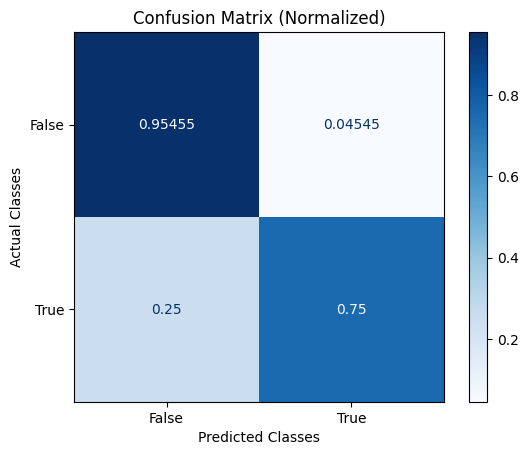

In [37]:
print(classification_report(true_labels, boolean_classifications, labels=[True, False]))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels.tolist(),
    predict_vector=boolean_classifications
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)